In [1]:
# import dt_apriltags as apriltag
import cv2
import glob
import numpy as np
from pathlib import Path
import re
# import pyrealsense2 as rs
# import urx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dist = np.array([[-0.04797802,  0.04744357,  0.00017416,  0.00067967, -0.00408397]])
detector = apriltag.Detector(families="tagStandard52h13")
mtx = np.array([[633.09029639, 0., 629.06462963], [0., 638.7544391, 362.74013262],[0., 0., 1.]])

camera_params = [633.0902963939839, 638.754439101168, 629.0646296262861, 362.7401326185789]



pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(stream_type=rs.stream.color, stream_index=0, width=1280, height=720, format=rs.format.rgb8, framerate=30)

profile = pipeline.start(config)

align_to = rs.stream.color
align = rs.align(align_to)

# ur10 = urx.Robot('192.168.88.139')
# ur10.is_running()

In [3]:
cv2.destroyAllWindows()
# pipeline.stop()

In [4]:
def draw_corners(img, r, show=False):
    imagePoints = r.corners.reshape(1,4,2)
    
    for corner in range(np.size(imagePoints[0],axis=0)):
        center = ((int(imagePoints[0][corner][0]),int(imagePoints[0][corner][1])))
        cv2.circle(img, center, 3, (0,0,255), -1)
    
    if show:
        cv2.imshow('img', color_image)

In [5]:
def detect_apriltag(img):
    if isinstance(img, str):
        print('reading img from file system')
        img = cv2.imread(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    results = detector.detect(gray,
                              estimate_tag_pose=True,
                              camera_params=camera_params, 
                              tag_size=0.04)
    if not results:
#         print('apriltag not found')
        return
    return results

In [6]:
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv.cvtColor(final_hsv, cv.COLOR_HSV2BGR)
    return img

In [7]:
def draw_apriltag(img, results, show=False):
    if not results: return
    if isinstance(img, str):
        img = cv2.imread(img)
    
    for r in results:
        (ptA, ptB, ptC, ptD) = r.corners
        ptA = int(ptA[0]), int(ptA[1])
#         ptB = int(ptB[0]), int(ptB[1])
#         ptC = int(ptC[0]), int(ptC[1])
#         ptD = int(ptD[0]), int(ptD[1])

#     # draw bbox
#         cv2.line(img, ptA, ptB, (0, 255, 0), 2)
#         cv2.line(img, ptB, ptC, (0, 255, 0), 2)
#         cv2.line(img, ptC, ptD, (0, 255, 0), 2)
#         cv2.line(img, ptD, ptA, (0, 255, 0), 2)
        draw_corners(img, r)
#     ptA = int(r.corners[0][0]), int(r.corners[0][1])
    
    # draw center
    cX, cY = int(r.center[0]), int(r.center[1])
    cv2.circle(img, (cX, cY), 5, (0, 0, 255), -1)
    
    # draw the tag family on the image
    tagFamily = r.tag_family.decode("utf-8")
    cv2.putText(img, tagFamily, (ptA[0], ptA[1] - 15),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
#     print("{}. [INFO] tag family: {} --- tag id: {}".format((i+1), 

    if show:
        cv2.imshow("Image", img)
        cv2.waitKey(10)

In [8]:
def get_photo_from_realsense(show=False):
    frames = pipeline.wait_for_frames()
    aligned_frames = align.process(frames)
    color_frame = aligned_frames.get_color_frame()

    color_image = np.asanyarray(color_frame.get_data()).copy() # copy() is important!!
    color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
    if show:
        cv2.imshow('img', color_image)
        cv2.waitKey(10)
    
    return np.array(color_image)

In [17]:
def solve_pnp(results):
    obj_points = np.zeros((5,3), dtype=float)
    obj_points[0][1] = 40.0
    obj_points[1][0] = 40.0
    obj_points[1][1] = 40.0
    obj_points[2][0] = 40.0
    obj_points[4][0] = 20.0
    obj_points[4][1] = 20.0
    
    

    for r in results:
        imagePoints = r.corners.reshape(1,4,2)
        center = r.center.reshape(1,1,2)
    
        imgpoints = np.concatenate((imagePoints, center), axis=1)
        success, rvec, tvec = cv2.solvePnP(obj_points, imgpoints, mtx, dist)
        
    if not success:
        print('not success in PnP')
        return
    return tvec, rvec

In [18]:
def draw_points(img, points, show=False):
    for i in range(len(points)):
        point = (int(points[i][0][0]), int(points[i][0][1]))
        cv2.circle(img, point, 2, (255,0,255), -1)
    
    if show:
        cv2.imshow('img', img)
        cv2.waitKey(10)
    

In [19]:
def draw_nums(img, points, show=False):
    for i in range(len(points)):
        point = (int(points[i][0][0]), int(points[i][0][1]))
        cv2.putText(img, str(i), point, cv2.FONT_HERSHEY_SIMPLEX, 12, (255,0,255))
        cv2.circle(img, point, 2, (255,0,255), -1)
    
    if show:
        cv2.imshow('img', img)
        cv2.waitKey(10)

In [20]:
def get_socket_points(img, points_array, lines_array, bbox_array, tvec, rvec, 
                      show=False, draw_l=True, draw_p=True, draw_b=True):
    if isinstance(img, str):
        img = cv2.imread(img)
#     img = increase_brightness(img, 50)
    
    if draw_p:
        img_points, _ = cv2.projectPoints(points_array, rvec, tvec, mtx, dist)
        draw_points(img, img_points)
    if draw_l:
        lines_points, _ = cv2.projectPoints(lines_array, rvec, tvec, mtx, dist)
        draw_lines(img, lines_points)
    if draw_b:
        bbox_arr, _ = cv2.projectPoints(bbox_array, rvec, tvec, mtx, dist)
        draw_bbox(img, bbox_arr)
    
    if show:
        cv2.imshow("Image", img)
        cv2.waitKey(0)
    return img

In [40]:
ur10.movel(pose_right)

<Transform:
<Orientation: 
array([[-0.60674916,  0.00105391,  0.79489266],
       [ 0.79221113, -0.08127912,  0.60481008],
       [ 0.06524559,  0.99669082,  0.04848112]])>
<Vector: (0.61362, -0.84578, 0.39675)>
>

In [23]:
# pose_left = ur10.getl()

In [26]:
# pose_center = ur10.getl()

In [27]:
# pose_right = ur10.getl()

In [54]:
DEPTH = -40
points_arr = np.zeros((17,3), np.float32)

points_arr[0, :] = [43, 145, 0]
points_arr[1, :] = [55, 143, 0]

points_arr[2, :] = [23, 139, 0]
points_arr[3, :] = [31, 139, 0]
points_arr[4, :] = [39, 139.5, 0]
points_arr[5, :] = [47, 139.5, 0]

points_arr[6, :] = [11, 146, 0]
points_arr[7, :] = [28, 146, 0]
points_arr[8, :] = [43, 146, 0]
points_arr[9, :] = [58, 146, 0]

points_arr[10, :] = [23, 152, 0]
points_arr[11, :] = [31, 152, 0]
points_arr[12, :] = [40, 152, 0]
points_arr[13, :] = [46, 152, 0]

points_arr[14, :] = [35, 159, 0]

points_arr[15, :] = [27, 166, 0]
points_arr[16, :] = [44, 166, 0]

points_arr[:,[0, 1]] = points_arr[:,[1, 0]]

points_arr[:, 2] = DEPTH

points_arr[:, 0] = -points_arr[:, 0]

bbox = np.array([
    [10, 128, DEPTH],
    [59, 128, DEPTH],
    [59, 170, DEPTH],
    [10, 170, DEPTH]
], dtype=float)
bbox[:,[0, 1]] = bbox[:,[1, 0]]
bbox[:, 0] = -bbox[:, 0]

In [55]:
# points_arr = np.zeros_like(points_arr)
# points_arr[0,:] = [-145, 43, 40]
# points_arr[1,:] = [-143, 55, -40]
# points_arr[2,:] = [-145, 43, 40]
# points_arr[3,:] = [-145, 43, 40]
# points_arr[4,:] = [-145, 43, 40]
# points_arr[5,:] = [-145, 43, 40]
# points_arr[6,:] = [-145, 43, 40]
# points_arr[7,:] = [-145, 43, 40]
# points_arr[8,:] = [-145, 43, 40]
# points_arr[9,:] = [-145, 43, 40]
# points_arr[10,:] = [-145, 43, 40]
# points_arr[11,:] = [-145, 43, 40]

In [56]:
lines = np.array([
    [0,0,0],
    [100,0,0],
    [0,100,0],
    [0,0,100]
], dtype=float)

In [57]:
bbox = np.array([
    [10, 128, DEPTH],
    [59, 128, DEPTH],
    [59, 170, DEPTH],
    [10, 170, DEPTH]
], dtype=float)
bbox[:,[0, 1]] = bbox[:,[1, 0]]
bbox[:, 0] = -bbox[:, 0]

In [59]:
def draw_bbox(img, bbox_arr, show=False):
    color = (0,255,0)
    cv2.line(img, 
            [int(x) for x in bbox_arr[0][0]],
            [int(x) for x in bbox_arr[1][0]], color, 1)
    cv2.line(img, 
            [int(x) for x in bbox_arr[1][0]], 
            [int(x) for x in bbox_arr[2][0]], color, 1)
    cv2.line(img, 
            [int(x) for x in bbox_arr[2][0]], 
            [int(x) for x in bbox_arr[3][0]], color, 1)
    cv2.line(img, 
            [int(x) for x in bbox_arr[3][0]], 
            [int(x) for x in bbox_arr[0][0]], color, 1)
    
    if show:
        cv2.imshow('img', img)
        cv2.waitKey(10)

In [60]:
def draw_lines(img, line_arr, show=False):
    colors = [(255,255,0), (0,255,0), (0,0,255)]
    for i, line in enumerate(line_arr[1:]):
        cv2.line(img, [int(x) for x in line_arr[0][0]], [int(x) for x in line[0]], colors[i-1], 2)
    if show:
        cv2.imshow('img', img)
        cv2.waitKey(10)

In [136]:
img = '/home/viacheslav/jupyter_notebooks/1_processed.jpg'
res = detect_apriltag(img)
tvec, rvec = solve_pnp(res)
_ = get_socket_points(img, points_arr, lines, bbox, tvec, rvec, 
                      show=True, draw_b=False)

reading img from file system


In [64]:
img = '/home/viacheslav/jupyter_notebooks/2_processed.jpg'
res = detect_apriltag(img)
tvec, rvec = solve_pnp(res)
_ = get_socket_points(img, points_arr, lines, bbox, tvec, rvec, 
                      show=True, draw_b=False)

reading img from file system


In [ ]:
cv2.imshow('img', cv2.imread('/home/viacheslav/jupyter_notebooks/2_processed.png'))

In [ ]:
name = 2
while True:
    img = get_photo_from_realsense()
    cv2.imshow('img', img)
    cv2.waitKey(1)
    res = detect_apriltag(img)
    if not res: 
        continue 
#     draw_apriltag(img, res)
    tvec, rvec = solve_pnp(res)
#     processed =  get_socket_points(img, points_arr, lines, bbox, tvec, rvec)
    fname = f'/home/viacheslav/jupyter_notebooks/{name}_processed.jpg'
    cv2.imwrite(fname, img)
    name += 1
    break
cv2.destroyAllWindows()

In [14]:
def make_photo(path='/home/viacheslav/jupyter_notebooks/processed_23_9', name=0):
    img = get_photo_from_realsense()
    res = detect_apriltag(img)
    if not res: 
        return name
    draw_apriltag(img, res)
    tvec, rvec = solve_pnp(res)
    processed = get_socket_points(img, points_arr, lines, bbox, tvec, rvec, draw_b=False, draw_l=False)
    cv2.imshow('img', img)
    cv2.waitKey(1)
    fname = path+f'/{name}_processed.jpg'
    cv2.imwrite(fname, processed)
    name += 1
    return name

In [15]:
def move_to_next_pos_and_photo(end:list, num_photos:int, img_name):
    start = ur10.getl()
    deltas = np.array([x-y for x, y in zip(end, start)])/num_photos
    for _ in range(num_photos):
        ur10.movel(ur10.getl()+deltas, vel=0.1, acc=0.5)
        img_name = make_photo(name=img_name)
    return img_name

In [17]:
cv2.destroyAllWindows()

In [64]:
ur10.getl()

[0.5293644400757425,
 -0.7471575815419071,
 0.5435782286442752,
 0.9689492506320426,
 1.4780741499662704,
 1.4508917642728367]

In [21]:
boundary_positions = []

In [29]:
boundary_positions.append(ur10.getl())

In [31]:
boundary_positions = np.array(boundary_positions)

In [32]:
boundary_positions

array([[ 0.232085  , -0.61961176,  0.43073168,  1.13699011,  1.24920145,
         1.22539067],
       [ 0.2333736 , -0.60270578,  0.63426659,  1.17489684,  1.22881322,
         1.24945387],
       [ 0.42691084, -0.61264868,  0.58616166,  1.3315313 ,  1.41684329,
         1.23695536],
       [ 0.29272549, -0.60669106,  0.33210261,  0.9753124 ,  0.95871666,
         1.43494421],
       [ 0.33165193, -0.25687359,  0.36506057,  1.30079001,  0.75824351,
         0.868352  ],
       [ 0.33153143, -0.22721475,  0.82933533,  1.67432401,  0.98844306,
         0.83238533],
       [ 0.44529088, -0.30760203,  0.6630999 ,  1.49787613,  1.12812965,
         0.9164792 ],
       [ 0.48105068, -0.37105609,  0.34244749,  1.08186592,  0.84939581,
         1.07530735]])

In [18]:
ur10.getl()

[0.613680548909852,
 -0.8457721957688374,
 0.3965869866472319,
 0.8664896819831868,
 1.6128040054787331,
 1.7493883084790065]

In [37]:
min_x, max_x = boundary_positions[:, 0].min(), boundary_positions[:, 0].max()
min_y, max_y = boundary_positions[:, 1].min(), boundary_positions[:, 1].max()
min_z, max_z = boundary_positions[:, 2].min(), boundary_positions[:, 2].max()
min_rx, max_rx = boundary_positions[:, 3].min(), boundary_positions[:, 3].max()
min_ry, max_ry = boundary_positions[:, 4].min(), boundary_positions[:, 4].max()
min_rz, max_rz = boundary_positions[:, 5].min(), boundary_positions[:, 5].max()

In [38]:
img_name = 0

In [ ]:
while True:
    next_pos = [np.random.uniform(min_x, max_x),
                np.random.uniform(min_y, max_y),
                np.random.uniform(min_z, max_z),
                np.random.uniform(min_rx, max_rx),
                np.random.uniform(min_ry, max_ry),
                np.random.uniform(min_rz, max_rz)]
    img_name = move_to_next_pos_and_photo(next_pos, 50, img_name)

In [42]:
pose_left = [0.4144699791608615,
 -0.28471817373934244,
 0.4506025223319278,
 1.3698459362193829,
 0.8751222887301229,
 0.7944053357672337]

[0.4144699791608615,
 -0.28471817373934244,
 0.4506025223319278,
 1.3698459362193829,
 0.8751222887301229,
 0.7944053357672337]

In [43]:
pose_center = [0.4168558559693215,
 -0.5621571861068889,
 0.4414088449025262,
 1.1886706848218183,
 1.2237760813323468,
 1.1861928832927722]

[0.4168558559693215,
 -0.5621571861068889,
 0.4414088449025262,
 1.1886706848218183,
 1.2237760813323468,
 1.1861928832927722]

In [44]:
pose_right = [0.613646044924774,
 -0.8457833066867604,
 0.39668770616099447,
 0.86630043677316,
 1.6128758106937202,
 1.7491595656007006]

[0.613646044924774,
 -0.8457833066867604,
 0.39668770616099447,
 0.86630043677316,
 1.6128758106937202,
 1.7491595656007006]

# Optimising the points

In [24]:
img = cv2.imread('/home/viacheslav/jupyter_notebooks/0_processed.png')
res = detect_apriltag(img)
rvec, tvec = solve_pnp(res)
keypoints, _ = cv2.projectPoints(points_arr, rvec, tvec, mtx, dist)
# draw_nums(img, keypoints, True)

In [49]:
img = cv2.imread('/home/viacheslav/jupyter_notebooks/1_processed.png')
red_pixel =  np.array([0, 0, 255])

In [154]:
cv2.destroyAllWindows()

In [26]:
def detect_red_pixels(path:str, img:np.array=None):
    red_pixel =  np.array([0,0, 255])
    if img is None:
        img = cv2.imread(path)
    indices = []
    for x, row in enumerate(img):
        for y, cell in enumerate(row):
            if np.array_equal(img[x, y], red_pixel):
                indices.append((x,y))
    assert len(indices) == 17, f'wrong keypoint number!! {indices}'
    return indices

In [27]:
px0 = np.array(detect_red_pixels('/home/viacheslav/jupyter_notebooks/0_processed.png'))
px1 = np.array(detect_red_pixels('/home/viacheslav/jupyter_notebooks/1_processed.png'))
px2 = np.array(detect_red_pixels('/home/viacheslav/jupyter_notebooks/2_processed.png'))

px0[[4, 5]] = px0[[5, 4]]

px1[[4, 5, 2, 3]] = px1[[2, 3, 4, 5]]
px1[[9, 8, 8, 6]] = px1[[6, 7, 8, 9]]
px1[[10,11,12,13]] = px1[[13, 12, 10, 11]]
px1[[15, 16]] = px1[[16,15]]

px2[[0,1]] = px2[[1,0]]
px2[[3,4,5]] = px2[[4,5,3]]
px2[[10,11]] = px2[[11,10]]

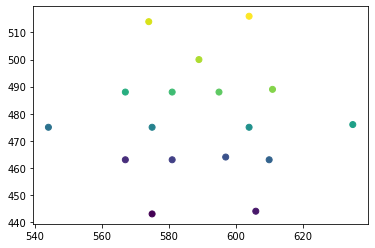

In [29]:
plt.scatter(px0[:,1], px0[:,0], c=range(len(px0)))

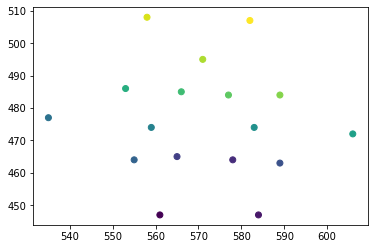

In [30]:
plt.scatter(px1[:,1], px1[:,0], c=range(len(px1)))

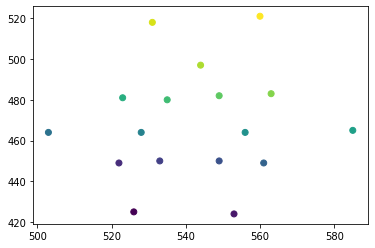

In [31]:
plt.scatter(px2[:,1], px2[:,0], c=range(len(px2)))

In [38]:
def distance(true_pixels, projected_pixel, num):
    while len(projected_pixel) != 2:
        projected_pixel = projected_pixel[0]

    proj = int(projected_pixel[0]), int(projected_pixel[1])

    return (proj[0] - true_pixels[num][0])**2 + (proj[1] - true_pixels[num][1])**2

In [49]:
def get_keypoints(img, points, num = -1):
    res = detect_apriltag(img)
    rvec, tvec = solve_pnp(res)
    if num == -1:
        keypoints, _ = cv2.projectPoints(points, rvec, tvec, mtx, dist)
    else:
        keypoints, _ = cv2.projectPoints(points[num], rvec, tvec, mtx, dist)
    for i, k in enumerate(keypoints):
        keypoints[i] = k[0]
    return keypoints

In [50]:
def get_dist_with_delta(points, imgs, delta, red_px, num):
    points_d = points.copy()
    if delta[0] != 0:
        points_d[num, 0] += delta[0]
    if delta[1] != 0:
        points_d[num, 1] += delta[1]
    if delta[2] != 0:
        points_d[num, 2] += delta[2]
    
    curr_dist = 0.

    for i, img in enumerate(imgs):
        keypoints = get_keypoints(img, points_d, num)
        curr_dist += sum([distance(red_px[i], keypoints, num)])
    return curr_dist

In [ ]:
POINT_NUM = 0

px0 = np.array(detect_red_pixels('/home/viacheslav/jupyter_notebooks/0_processed.png'))
px1 = np.array(detect_red_pixels('/home/viacheslav/jupyter_notebooks/1_processed.png'))
px2 = np.array(detect_red_pixels('/home/viacheslav/jupyter_notebooks/2_processed.png'))

px0[[4, 5]] = px0[[5, 4]]

px1[[4, 5, 2, 3]] = px1[[2, 3, 4, 5]]
px1[[9, 8, 8, 6]] = px1[[6, 7, 8, 9]]
px1[[10,11,12,13]] = px1[[13, 12, 10, 11]]
px1[[15, 16]] = px1[[16,15]]

px2[[0, 1]] = px2[[1, 0]]
px2[[3, 4, 5]] = px2[[4, 5, 3]]
px2[[10, 11]] = px2[[11, 10]]

red_px = [px0, px1, px2]



imgs = [
    cv2.imread(x) for x in ['/home/viacheslav/jupyter_notebooks/0_processed.jpg',
    '/home/viacheslav/jupyter_notebooks/1_processed.jpg',
    '/home/viacheslav/jupyter_notebooks/2_processed.jpg']]


points = points_arr.copy()
curr_dist = 0.

for i, img in enumerate(imgs):
    keypoints = get_keypoints(img, points, POINT_NUM)
    curr_dist += sum([distance(red_px[i], keypoints, POINT_NUM)])

deltas = [
    [1, 0, 0],
    [-1,0, 0],
    [0, 1, 0],
    [0,-1, 0],
    [0, 0, 1],
    [0, 0,-1],
    [0, 0, 0]
]


min_dist = curr_dist
print(min_dist, 'min dist initial')
min_delta = 2
ok = True
for k in range(17):
    while min_delta != 6:
        dists = np.array([get_dist_with_delta(points, imgs, delta, red_px, POINT_NUM) for delta in deltas])
        print(dists)
        min_delta = np.argmin(dists)
        min_dist = dists[min_delta]
        
        points[POINT_NUM, :] += min_delta
        print(POINT_NUM, ':', points[POINT_NUM])
    POINT_NUM = k

In [ ]:
px0 = np.array(detect_red_pixels('/home/viacheslav/jupyter_notebooks/0_processed.png'))
px1 = np.array(detect_red_pixels('/home/viacheslav/jupyter_notebooks/1_processed.png'))
px2 = np.array(detect_red_pixels('/home/viacheslav/jupyter_notebooks/2_processed.png'))

px0[[4, 5]] = px0[[5, 4]]

px1[[4, 5, 2, 3]] = px1[[2, 3, 4, 5]]
px1[[9, 8, 8, 6]] = px1[[6, 7, 8, 9]]
px1[[10,11,12,13]] = px1[[13, 12, 10, 11]]
px1[[15, 16]] = px1[[16,15]]

px2[[0, 1]] = px2[[1, 0]]
px2[[3, 4, 5]] = px2[[4, 5, 3]]
px2[[10, 11]] = px2[[11, 10]]

red_px = [px0, px1, px2]

imgs = [
    cv2.imread(x) for x in ['/home/viacheslav/jupyter_notebooks/0_processed.jpg',
    '/home/viacheslav/jupyter_notebooks/1_processed.jpg',
    '/home/viacheslav/jupyter_notebooks/2_processed.jpg']]

for i, img in enumerate(imgs):
    keypoints = get_keypoints(img, points)
    print(keypoints)

In [466]:
points

array([[-106. ,   93. ,   -6. ],
       [-143. ,   55. ,  -40. ],
       [-139. ,   23. ,  -40. ],
       [-139. ,   31. ,  -40. ],
       [-139.5,   39. ,  -40. ],
       [-139.5,   47. ,  -40. ],
       [-146. ,   11. ,  -40. ],
       [-146. ,   28. ,  -40. ],
       [-146. ,   43. ,  -40. ],
       [-146. ,   58. ,  -40. ],
       [-152. ,   23. ,  -40. ],
       [-152. ,   31. ,  -40. ],
       [-152. ,   40. ,  -40. ],
       [-152. ,   46. ,  -40. ],
       [-159. ,   35. ,  -40. ],
       [-166. ,   27. ,  -40. ],
       [-166. ,   44. ,  -40. ]], dtype=float32)

In [83]:
cv2.destroyAllWindows()

In [3]:
img = cv2.imread(r'C:\Users\snipercapt\Desktop\Python_notebooks\apriltag\no_marker_close_new.jpg')
cv2.imshow('i', img)
cv2.waitKey(0)

-1

In [17]:
edges = cv2.Canny(img,40,90, True)
cv2.imshow('edges', edges)
cv2.waitKey(0)

-1

In [18]:
kernel = np.ones((5,5),np.float32)/25
dst = cv2.filter2D(edges,-1,kernel)
# cv2.imshow('smooth', dst)
# cv2.waitKey(0)

In [25]:
# circles = cv2.HoughCircles(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cv2.HOUGH_GRADIENT, 1.2, 100)
circles = cv2.HoughCircles(dst, cv2.HOUGH_GRADIENT, dp=1.5, maxRadius=100, minRadius=40, 
                           minDist=30, param2=80)
out = img.copy()
print(circles)
for x, y, r in circles[0]:
    cv2.circle(out, (int(x), int(y)), int(r), (0, 255, 0), 4)
    cv2.rectangle(out, (int(x) - 2, int(y) - 2), (int(x) + 2, int(y) + 2), (0, 128, 255), -1)
cv2.imshow('circles', out)
cv2.waitKey(0)

[[[822.75 362.25  61.15]
  [752.25 476.25  61.15]
  [690.75 365.25  66.1 ]
  [626.25 477.75  61.15]
  [554.25 363.75  61.  ]
  [755.25 270.75  43.  ]
  [621.75 270.75  46.3 ]]]


-1

In [1]:
cv2.HoughCircles??

Object `cv2.HoughCircles` not found.
